# "Mapas de puntos con Python"
> "Conoce y aprende a hacer este tipo de mapas que es muy útil para visualizar resultados electorales geográficamente."
- toc: true
- badges: true
- comments: true
- categories: [geopandas, mapas, datamexico]
- permalink: /mapas-distribucion-puntos/

> Elaborado por Juan Javier Santos Ochoa ([@jjsantoso](https://twitter.com/jjsantoso), www.jjsantoso.com)

En esta entrada les cuento sobre este mapa de puntos que hice y tuvo bastante eco en redes sociales.
> twitter: https://twitter.com/jjsantoso/status/1402393589091549185

Se trata de un [mapa de puntos](http://redgeomatica.rediris.es/carto2/pdf/pdfT/tema4t.pdf), también conocidos como mapa de distribución de puntos o mapa de densidad de puntos. En este tipo de mapa los polígonos de cada región se rellenan de puntos que representan una cantidad fija. Cada punto puede representar una sola observación o varias, lo importante es que ese valor se mantenga fijo y no varíe, como pudiera ser en un [mapa de símbolos proporcionales](http://redgeomatica.rediris.es/carto2/pdf/pdfT/tema3t.pdf). Cuando los puntos tienen el mismo valor es mucho más fácil hacer comparaciones. Normalmente la ubicación de cada punto dentro de la región que le corresponde no indica la ubicación exacta y muchas veces simplemente se distribuyen de forma aleatoria dentro del polígono.

A continuación describiré por qué me parecio que este mapa era adecuado en el contexto de la discusión de la polarización política de la Ciudad de México. Luego mostraré cómo fue que hice este mapa (para esta parte se necesita tener conocimientos de Python y las librerías Numpy, Pandas y Geopandas). Por último finalizaré con algunas reflexiones sobre este ejercicio.

# Motivación

Tras los primeros resultados de la jornada electoral del 6 de junio empezaron a circular varios mapas, mostrando los ganadores de las alcaldías en la Ciudad de México.

![](imagenes/mapa_puntos/division_cdmx.png "tomado de: https://www.bbc.com/mundo/noticias-america-latina-57408084")

Estos mostraban que la ciudad quedó dividida en poniente/oriente por las dos principales fuerzas políticas. El poniente "de derecha" versus el oriente de "izquierda". Para quienes no conocen la CDMX, además hay un fuerte componente socioeconómico en esta división que se creó, como bien ha documentado [Máximo Jaramillo](https://twitter.com/rojo_neon/status/1402632271505539078).  Se empezó a hablar del "muro de Berlín", pero entre meme y meme se empezó a asomar el clasismo/racismo de varios. Se empezaron a sacar conclusiones simplistas de que los del poniente son X, mientras los de oriente son Y. 

Varios advirtieron que la división realmente no era tan dramática como parecía sugerir el mapa, porque en muchas alcaldías la victoria estuvo reñida. Pero eso no se podía ver en el mapa de la división, ahí solo cabe el ganador. Ese es un primer problema de los mapas coropléticos, no permiten mostrar más de una variable a la vez, para cada polígono solo podemos ver un solo valor (o color). Hay [mapas bivariados](https://en.wikipedia.org/wiki/Multivariate_map), pero su alcance es limitado (y a mí personalmente no me gustan mucho). Mi primer objetivo entonces era poder mostrar que el voto no estaba totalmente inclinado hacia un lado u otro, sino que había diversidad en todas las alcaldías. Eso se puede mostrar usando otros tipos de gráficos, por ejemplo gráficos de barras, pero sentía que el impacto de los primeros mapas provenía de la división geográfica y que otro tipo de gráfica no reflejaba eso, entonces necesitaba un mapa para vencer a otro mapa. La división poniente/oriente existe, pero hay que dimensionarla en sus justas proporciones.

Un segundo problema de los mapas coropléticos es que el área causa una distorsión en la percepción porque las áreas más grandes sobresalen. Y en mapas de resultados electorales eso afecta mucho el mensaje, porque el dominio territorial de áreas grandes parece indicar mayor dominio político. El típico problema de "La tierra no vota, las personas sí". Enrique Tejada lo explica mejor en su [blog](https://twitter.com/enriquegtejeda/status/1403064483883388928).

![](imagenes/mapa_puntos/land_people_vote.jpg)

Con eso en mente, recordé que sensei [Segasi](https://twitter.com/segasi) había publicado alguna vez un mapa de puntos y me pareció que esa era una buena forma de representarlo: permitía mostrar la diversidad del voto y no exageraba la participación política de ningún partido. Sin embargo, los mapas de puntos normalmente distribuyen los puntos de manera aleatoria dentro del polígono, y eso me parece algo confuso, porque no permite dimensionar claramente qué partido tiene más o menos votos, además de que uno puede pensar que la ubicación del punto corresponde a una posición real, cuando no es así. Pensé entonces que necesitaba un mapa de puntos en el que yo pudiera definir la ubicación de los puntos de forma contigua para que fuera más fácil hacer comparaciones.

Esta forma de visualizar me parece tiene varias ventajas:
* Permite dimensionar la participación electoral: quiénes votaron y los que no.
* Permite ver la distribución del voto entre los distintos partidos dentro de cada alcaldía.
* Reduce sustancialmente el sesgo por tamaño de la alcaldía.

También es necesario ser conscientes de las desventajas o sesgos que puede haber en este tipo de mapa:
* No es adecuado si hay polígonos que son relativamente muy pequeños, porque no sería posible ver adecuadamente los puntos al interior. Por eso sería difícil hacer un mapa similar a nivel colonia o sección electoral.
* Las alcaldías más pequeñas pueden parecer que tienen más participación porque se ven más "rellenas" de puntos.
* La posición de los puntos no indica nada, pero es posible que algunos lo tomen como la ubicación de las casillas.
* El espacio en blanco sobrante (donde no hay puntos) puede confundirse con abstención.

Haciendo el balance, me parece que las ventajas son mayores a las desventajas para este problema particular.

Así fue como llegué a la idea del mapa, ahora el reto era hacerlo, porque hasta donde yo sabía no hay un programa o librería que los hiciera directamente. Me puse a experimentar con Python y llegué a lo que sigue a continuación.

# Elaboración del mapa

Lo que sigue es bastante técnico y se requiere conocer bien las librerías más comunes de análisis de datos dentro del ecosistema de Python.

Lo primero que necesitamos para llegar al mapa de puntos (además de importar las librerías) es poder rellenar cada polígono con puntos. La idea a la que llegue para hacerlo es la siguiente:
1. Obtener los bordes (inferior izquierdo, superior derecho) de cada polígono.
2. Hacer una cuadrícula de puntos equidistantes usando los bordes.
3. Seleccionamos solo los puntos de la cuadrícula que están contenidos por el polígono original.

Veamos paso a paso cómo se hace esto.

In [1]:
# importando librerías
from math import ceil
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print(sys.version)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)
print(np.__name__, np.__version__)
print(plt.matplotlib.__name__, plt.matplotlib.__version__)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]
pandas 0.24.2
geopandas 0.6.3
numpy 1.18.1
matplotlib 3.2.1


Leemos el mapa de alcaldías de la CDMX. Se puede [descargar aquí](http://jjsantoso.com/blog/datos/mapa_mexico.zip).

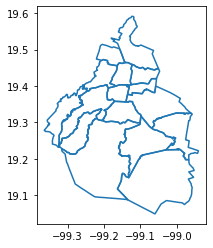

In [2]:
cdmx = gpd.read_file('datos/mapa_mexico/')\
    .query('CVE_EDO=="09"')\
    .set_index('CLAVE')
cdmx.boundary.plot()

Vamos a seleccionar solo una alcaldía para ilustrar el proceso

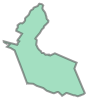

In [3]:
poly_index = '09005'
poly = cdmx.loc[poly_index, 'geometry']
poly

Obtengamos los bordes de este polígono:

In [4]:
x0, y0, x1, y1 = poly.bounds
print(x0, y0, x1, y1)

-99.18007062292732 19.44414241268417 -99.05068100445773 19.59186051804424


Vamos a crear una cuadrícula de puntos que estén separados a una distancia de 0.005 unidades decimales. Creamos la cuadrícula usando Numpy, luego la transformamos en un GeoDataframe para que sea posible hacer la unión espacial.

>Warning: la distancia depende del sistema de coordenadas geográficas que estén usando. En este caso yo tengo WGS84 que usa coordenadas planas.

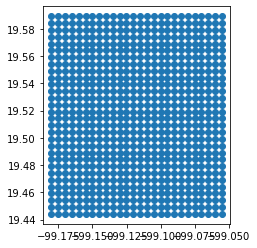

In [5]:
distancia = 0.005
# Cuadrícula de puntos
X, Y = np.meshgrid(np.arange(x0, x1, distancia), np.arange(y0, y1, distancia))
# lo convertimos en geodataframe
df_puntos_alc = pd.DataFrame(np.array([X.flatten(), Y.flatten()]).T, columns=['X', 'Y'])\
    .assign(CLAVE=poly_index)\
    .pipe(lambda df: gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y'])))

# así se ve
df_puntos_alc.plot()

¿Cómo sabemos cuáles de estos puntos caen dentro del área del polígono `poly`? Fácil, usamos el método `.within` de los GeodataFrames para saber cuáles están dentro.

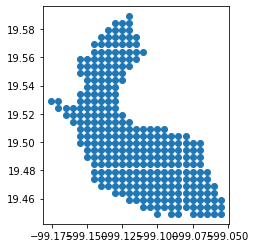

In [6]:
df_puntos_alc = df_puntos_alc.loc[df_puntos_alc.within(poly)]
df_puntos_alc.plot()

Ahora lo hacemos para todas las alcaldías usando un loop. El resultado se guarda en el GeoDataframe `df_xy`

In [7]:
lista_df_puntos = list()
for poly_index in cdmx.index:
    poly = cdmx.loc[poly_index, 'geometry']
    x0, y0, x1, y1 = poly.bounds
    x = np.arange(x0, x1, 0.005)
    y = np.arange(y0, y1, 0.005)
    X,Y = np.meshgrid(x, y)
    df_puntos_alc = pd.DataFrame(np.array([X.flatten(), Y.flatten()]).T, columns=['X', 'Y'])\
        .assign(CLAVE=poly_index)\
        .pipe(lambda df: gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y'])))\
        .loc[lambda df: df.within(poly)]
    lista_df_puntos.append(df_puntos_alc.iloc[::-1])
    
df_xy = pd.concat(lista_df_puntos, axis=0)
df_xy.crs = {'init': 'epsg:4326'}
df_xy.tail()

,X,Y,CLAVE,geometry
104,-99.072886,19.058221,09009,POINT (-99.07289 19.05822)
103,-99.077886,19.058221,09009,POINT (-99.07789 19.05822)
64,-99.057886,19.053221,09009,POINT (-99.05789 19.05322)
63,-99.062886,19.053221,09009,POINT (-99.06289 19.05322)
62,-99.067886,19.053221,09009,POINT (-99.06789 19.05322)


Con esto cumplimos la primera parte. La siguiente es determinar cuántos votos debería representar cada punto. Para eso, necesito tener los resultados de la votación por alcaldía. Los datos los descargue del [PREP](https://prep2021cdmx.eluniversal.com.mx/prep2021/base-de-datos.php?t1p0=A&1ds3cc10n=0&c4s=0&dt0=0). Así lucen:

In [8]:
prep_cdmx = pd.read_csv('datos/prep_cdmx/CDMX_ALC_2021.csv', header=4)
prep_cdmx.head(3)

,CLAVE_CASILLA,CLAVE_ACTA,ID_ESTADO,ESTADO,ID_DISTRITO,ALCALDIA,SECCION,ID_CASILLA,TIPO_CASILLA,EXT_CONTIGUA,...,OBSERVACIONES,CONTABILIZADAS,MECANISMOS_TRASLADO,SHA,FECHA_HORA_ACOPIO,FECHA_HORA_CAPTURA,FECHA_HORA_VERIFICACION,ORIGEN,DIGITALIZACION,TIPO_DOCUMENTO
0,090056B0100,090056B0100ALC,9,CIUDAD DE MEXICO,3,AZCAPOTZALCO,56,1,B,0,...,NaN,1,F,043b1e8ffdf059edb68828172f271400111a56b3e769c3...,2021-06-07 04:11,07/06/2021 06:40:29 a.m.,07/06/2021 10:26:14 a.m.,CATD,ESCANER,ACTA_PREP
1,090056C0100,090056C0100ALC,9,CIUDAD DE MEXICO,3,AZCAPOTZALCO,56,1,C,0,...,NaN,1,F,ba2338cdbabd8ec0b1f53620f704cb94f1d408d668eae4...,2021-06-07 01:36,07/06/2021 10:17:50 a.m.,07/06/2021 10:18:19 a.m.,CATD,ESCANER,ACTA_PREP
2,090056C0200,090056C0200ALC,9,CIUDAD DE MEXICO,3,AZCAPOTZALCO,56,2,C,0,...,NaN,1,F,2ec62e039cddb9850477535904f4523e2be055147516f0...,06/06/2021 10:23:32 p.m.,06/06/2021 10:23:32 p.m.,06/06/2021 10:26:07 p.m.,CASILLA,MOVIL,ACTA_PREP


Los resultados vienen a nivel casilla, así que hay que agregarlos por alcaldía. También hay que sumar los votos de las coaliciones y crear una variable que contenga la clave INEGI de cada municipio. Todo eso se hace a continuación:

In [9]:
dicc_alc_cve = {
    'ALVARO OBREGON': '09010',
    'AZCAPOTZALCO': '09002',
    'BENITO JUAREZ': '09014',
    'COYOACAN': '09003',
    'CUAJIMALPA DE MORELOS': '09004',
    'CUAUHTEMOC': '09015',
    'GUSTAVO A. MADERO': '09005',
    'IZTACALCO': '09006',
    'IZTAPALAPA': '09007',
    'LA MAGDALENA CONTRERAS': '09008',
    'MIGUEL HIDALGO': '09016',
    'MILPA ALTA': '09009',
    'TLAHUAC': '09011',
    'TLALPAN': '09012',
    'VENUSTIANO CARRANZA': '09017',
    'XOCHIMILCO': '09013'
}

alianza_pan = ['PAN', 'PRI', 'PRD', 'PAN_PRI_PRD', 'PAN_PRI', 'PAN_PRD', 'PRI_PRD']
alianza_morena = ['PVEM', 'PT','MORENA', 'PVEM_PT_MORENA', 'PVEM_PT', 'PVEM_MORENA', 'PT_MORENA']
prep_alc = prep_cdmx[alianza_morena + alianza_pan + ['TOTAL_VOTOS_ASENTADOS', 'LISTA_NOMINAL']].apply(pd.to_numeric, errors='coerce')\
    .assign(alianza_pan_pri_prd=lambda x: x[alianza_pan].sum(axis=1),
            alianza_morena_pt_pvem=lambda x: x[alianza_morena].sum(axis=1),
            no_voto=lambda x: x['LISTA_NOMINAL']-x['TOTAL_VOTOS_ASENTADOS']
           )\
    .join(prep_cdmx['ALCALDIA'])\
    .groupby('ALCALDIA', as_index=False).sum()\
    .assign(CLAVE=lambda x: x['ALCALDIA'].map(dicc_alc_cve))
prep_alc.head()

,ALCALDIA,PVEM,PT,MORENA,PVEM_PT_MORENA,PVEM_PT,PVEM_MORENA,PT_MORENA,PAN,PRI,...,PAN_PRI_PRD,PAN_PRI,PAN_PRD,PRI_PRD,TOTAL_VOTOS_ASENTADOS,LISTA_NOMINAL,alianza_pan_pri_prd,alianza_morena_pt_pvem,no_voto,CLAVE
0,ALVARO OBREGON,5617.0,4235.0,99544.0,716.0,54.0,242.0,867.0,106448.0,43975.0,...,5213.0,739.0,365.0,207.0,327271.0,607719,182181.0,111275.0,278460.0,09010
1,AZCAPOTZALCO,5346.0,2785.0,71225.0,0.0,0.0,0.0,898.0,57933.0,21612.0,...,2048.0,357.0,108.0,38.0,200058.0,381398,86337.0,80254.0,171959.0,09002
2,BENITO JUAREZ,1620.0,1524.0,44052.0,0.0,0.0,0.0,700.0,157178.0,13086.0,...,0.0,0.0,0.0,0.0,230967.0,373323,172336.0,47896.0,131402.0,09014
3,COYOACAN,5371.0,4299.0,110098.0,0.0,0.0,0.0,1353.0,105089.0,37422.0,...,4908.0,625.0,255.0,143.0,316558.0,559122,168872.0,121121.0,226813.0,09003
4,CUAJIMALPA DE MORELOS,2501.0,1670.0,26501.0,0.0,0.0,0.0,407.0,23736.0,44779.0,...,1471.0,281.0,29.0,100.0,112968.0,178825,72304.0,31079.0,64446.0,09004


Vamor ahora a unir los resultados de la votación con el GeoDataframe de las alcaldías de la ciudad.


In [10]:
cdmx = gpd.read_file('datos/mapa_mexico/')\
    .query('CVE_EDO=="09"')\
    .merge(prep_alc, on='CLAVE')\
    .set_index('CLAVE')
cdmx.head(2)

,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,ALCALDIA,PVEM,PT,MORENA,...,PRD,PAN_PRI_PRD,PAN_PRI,PAN_PRD,PRI_PRD,TOTAL_VOTOS_ASENTADOS,LISTA_NOMINAL,alianza_pan_pri_prd,alianza_morena_pt_pvem,no_voto
CLAVE,,,,,,,,,,,,,,,,,,,,,
09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588...",GUSTAVO A. MADERO,14623.0,10753.0,219742.0,...,47959.0,4850.0,864.0,421.0,402.0,527327.0,1051850,212862.0,248042.0,519352.0
09002,Azcapotzalco,D.F.,09,002,33.420781,"POLYGON ((-99.15688 19.50231, -99.15684 19.502...",AZCAPOTZALCO,5346.0,2785.0,71225.0,...,4241.0,2048.0,357.0,108.0,38.0,200058.0,381398,86337.0,80254.0,171959.0


El número de votos que vale cada punto es un parámetro clave que se establece un poco por ensayo y error, no hay un número predeterminado. En este [post](https://www.axismaps.com/guide/dot-density) dan algunos consejos a tener en cuenta. Lo principal es que hay que cuidar el balance entre número y tamaño de los puntos para que ningún área se vea demasiado densa o que los puntos sean tan pequeños que no sea posible identificar claramente su color. Para encontrar el número aproximado de puntos lo que hice fue dividir el padrón electoral de cada alcaldía entre el número de puntos de la cuadrícula con forma de polígono. De entre todas las alcaldías me fijé en el valor mínimo. Eso garantiza que al menos para la delegación más pequeña habrá suficientes puntos para que toda su población esté representada. En este caso me dio que cada punto debería valer al menos 4217.3 votos. Cuaqluier valor por encima de eso nos serviría. Escogí finalmente 5,000 porque me parece que logra un buen balance entre visibilidad sin hacer que se vean áreas demasiado densas.

In [11]:
# Número aproximado de votos que debería valer cada voto
aprox_voto_punto = df_xy.groupby('CLAVE')[['Y']].count().join(cdmx[['TOTAL_VOTOS_ASENTADOS', 'no_voto']])\
    .assign(voto_por_punto=lambda x: x['TOTAL_VOTOS_ASENTADOS'].add(x['no_voto']).div(x['Y']))\
    .get('voto_por_punto').max()
print('Número aproximado de votos que debería valer cada punto', aprox_voto_punto)
voto_x_punto_participacion = 5000
print('Número de votos que vale cada punto seleccionado', voto_x_punto_participacion)

Número aproximado de votos que debería valer cada punto 4217.3
Número de votos que vale cada punto seleccionado 5000


Lo que sigue ahora es determinar cuántos puntos en total deben quedarse en cada alcaldía, cuántos van a estar coloreados para cada coalición y las personas que no votaron. Hagámoslo para una delegación:

In [18]:
poly_index = '09005'
puntos_novoto = int(ceil(cdmx.loc[poly_index, 'no_voto'] / voto_x_punto_participacion))
puntos_morena = int(ceil(cdmx.loc[poly_index, 'alianza_morena_pt_pvem'] / voto_x_punto_participacion))
puntos_pan = int(round(cdmx.loc[poly_index, 'alianza_pan_pri_prd'] / voto_x_punto_participacion))
puntos_total_partidos = int(ceil(cdmx.loc[poly_index, 'TOTAL_VOTOS_ASENTADOS'] / voto_x_punto_participacion))
puntos_otros = puntos_total_partidos - puntos_morena - puntos_pan
print(puntos_novoto, puntos_morena, puntos_pan, puntos_otros)

104 50 43 13


Así tengo, por ejemplo, que en la alcaldía Gustavo A. Madero voy a usar en total 210 puntos distribuídos de la siguiente manera:
* 104 no votaron
* 50 a la coalición de MORENA, PT, PVEM
* 43 a la coalición de PAN, PRI, PRD
* 13 a otros partidos/candidatos independientes

Ya solo queda graficar. Así se va haciendo partido a partido:

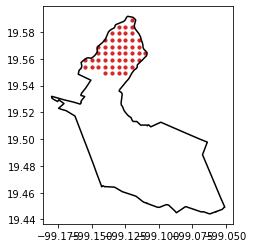

In [19]:
fig, ax = plt.subplots()
cdmx.loc[[poly_index]].boundary.plot(color='k', ax=ax)
df_xy.query('CLAVE==@poly_index').iloc[:puntos_morena].plot(ax=ax, markersize=10, color='C3', label='Alianza MORENA-PT-PVEM')

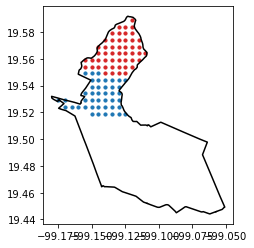

<Figure size 432x288 with 0 Axes>

In [20]:
df_xy.query('CLAVE==@poly_index').iloc[puntos_morena: puntos_morena + puntos_pan].plot(ax=ax, markersize=10, color='C0', label='Alianza PAN-PRI-PRD')
fig

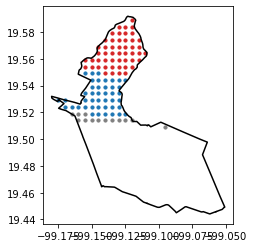

<Figure size 432x288 with 0 Axes>

In [21]:
df_xy.query('CLAVE==@poly_index').iloc[puntos_morena + puntos_pan: puntos_total_partidos].plot(ax=ax, markersize=10, color='gray', label='Otros')
fig

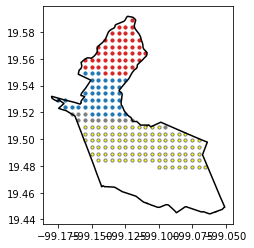

<Figure size 432x288 with 0 Axes>

In [22]:
df_xy.query('CLAVE==@poly_index').iloc[puntos_total_partidos: puntos_total_partidos + puntos_novoto].plot(ax=ax, markersize=10, facecolor='yellow', edgecolor='gray', label='No votaron')
fig

Pues ya, un loop que lo haga para todas las alcaldías:

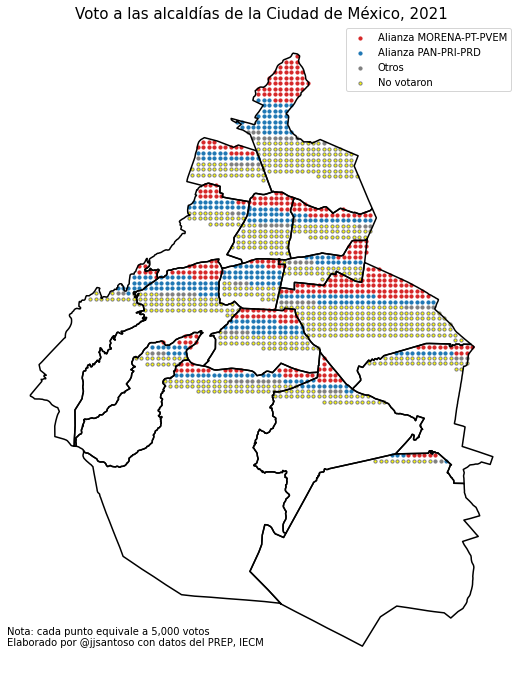

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
for poly_index in cdmx.index:
    puntos_total_partidos = int(ceil(cdmx.loc[poly_index, 'TOTAL_VOTOS_ASENTADOS'] / voto_x_punto_participacion))
    puntos_novoto = int(ceil(cdmx.loc[poly_index, 'no_voto'] / voto_x_punto_participacion))
    puntos_morena = int(ceil(cdmx.loc[poly_index, 'alianza_morena_pt_pvem'] / voto_x_punto_participacion))
    puntos_pan = int(round(cdmx.loc[poly_index, 'alianza_pan_pri_prd'] / voto_x_punto_participacion))
    puntos_otros = puntos_total_partidos - puntos_morena - puntos_pan
    cdmx.loc[[poly_index]].boundary.plot(color='k', ax=ax)
    df_xy.query('CLAVE==@poly_index').iloc[:puntos_morena].plot(ax=ax, markersize=10, color='C3', label='Alianza MORENA-PT-PVEM')
    df_xy.query('CLAVE==@poly_index').iloc[puntos_morena: puntos_morena + puntos_pan].plot(ax=ax, markersize=10, color='C0', label='Alianza PAN-PRI-PRD')
    df_xy.query('CLAVE==@poly_index').iloc[puntos_morena + puntos_pan: puntos_total_partidos].plot(ax=ax, markersize=10, color='gray', label='Otros')
    df_xy.query('CLAVE==@poly_index').iloc[puntos_total_partidos: puntos_total_partidos + puntos_novoto].plot(ax=ax, markersize=10, facecolor='yellow', edgecolor='gray', label='No votaron')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:4], labels[0:4])
ax.set_axis_off()
ax.set_title('Voto a las alcaldías de la Ciudad de México, 2021', pad=5, fontsize=15)
ax.annotate(s=f'Nota: cada punto equivale a {voto_x_punto_participacion:,.0f} votos\nElaborado por @jjsantoso con datos del PREP, IECM', xy=(0, 50), xycoords='axes points', va='top', fontsize=10)
fig.savefig('graficas/voto_alcaldia_cdmx__participacion2021.png', dpi=600, bbox_inches='tight')

¡Listo!

# Reflexiones finales

El mapa tuvo muy buen recibimiento y creo que la mayoría de personas entendió el mensaje que quería transmitir: la ciudad no está tan divida como nos decían que estaba. Algunos comentaron que era difícil conocer el total de votos de cada alcaldía, lo cual es cierto. Otros sugirieron otros tipos de análisis que se alejaban un poco del propósito inicial. Como en cualquier problema complejo, una sola visualización no puede ofrecer el panorama completo y es necesario acompañar cualquier análisis de más datos y distintos tipos de visualizaciones. Cada una puede mostrar una faceta del problema de estudio y juntas llegan a una conclusión mucho mejor. 

Aunque por todo lo que dije antes parece que no me gustan los mapas coropléticos, eso no es para nada cierto, yo los uso mucho también. Cada mapa tiene su uso, depende del mensaje que se quiera transmitir. Debemos ser conscientes de las fortalezas y debilidades de cada forma de visualizar y ser cuidadosos para que, aunque tengamos las mejores intenciones, no terminemos mandando el mensaje equivocado.

En las muy reñidas elecciones presidenciales de Perú anda circulando este mapa. ¿Qué les decimos?

![](imagenes/mapa_puntos/empate_peru.jpg)


Si les interesa hacer mapas en Python también escribí esta otra entrada en mi blog:
* [Recuadros para mapas en Geopandas](https://blog.jjsantoso.com/zoom-mapas-geopandas/)

## Revisa otras entradas de este blog:
* [Integración de PyQGIS con Jupyter Lab usando Anaconda](/pyqgis-anaconda)
* [Introducción a PyQGIS (Python + QGIS)](/intro-pyqgis/)
* [Introducción a bases de datos relacionales y SQL para científicos sociales](/intro-sql-sociales/)
* [Recuadros para mapas en Geopandas](/zoom-mapas-geopandas/)
* [Etiquetado de variables y valores en las encuestas de INEGI usando Python](/etiquetas-encuestas-inegi/)
* [Generando archivos de Excel con formatos y gráficas usando Python](/excel-formato-graficas/)
* [Trabajando con archivos de Excel complejos en Pandas](/pandas-excel/)
